In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict
import matplotlib as plt

In [2]:
env = gym.make('Blackjack-v0')

## Using off-policy Monte Carlo method to solve Blackjack environment


In [3]:
def sample_policy(observation):
    """
    sticks if player score is >= 17 and hits otherwise
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 17 else 1

In [4]:
def get_random_policy(nA):
    
    R = np.ones(nA, dtype=float) / nA
    def policy_fn(obs):
        return R
    return policy_fn

def get_greedy_policy(env,Q):
    
    def policy(obs):
        P = np.zeros_like(Q[obs], dtype=float)
        best_action = np.argmax(Q[obs])  
        P[best_action] = 1
        return P
    return policy

In [5]:
def mc_prediction(policy, env, num_episodes, gamma):
    
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    target_policy = get_greedy_policy(env, Q)
        
    for i_episode in range(1, (num_episodes + 1)):
        

        
        episode = []
        state = env.reset()
        for t in range(100):
            probs = target_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        
        G = 0.0
        W = 1.0
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = gamma * G + reward
            C[state][action] += W
            
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
        
    return Q, target_policy

In [6]:
def calc_payoffs(env,rounds,players,pol):
    
    average_payouts = []
    for player in range(players):
        rd = 1
        total_payout = 0 
        while rd <= rounds:
            action = np.argmax(pol(env._get_obs()))
            obs, payout, is_done, _ = env.step(action)
            if is_done:
                total_payout += payout
                env.reset() 
                rd += 1
        average_payouts.append(total_payout)

    plt.plot(average_payouts)                
    plt.xlabel('num_player')
    plt.ylabel('reward after ' + str(rounds) + 'rounds')
    plt.show()    
    print ("Average reward of a player after {} rounds is {}".format(rounds, sum(average_payouts)/players))

In [7]:
env = gym.make('Blackjack-v0')
env.reset()
rand = get_random_policy(env.action_space.n)
Q, policy = mc_prediction(rand, env, 500000, 0.9)

Using Practical-4 for demonstration

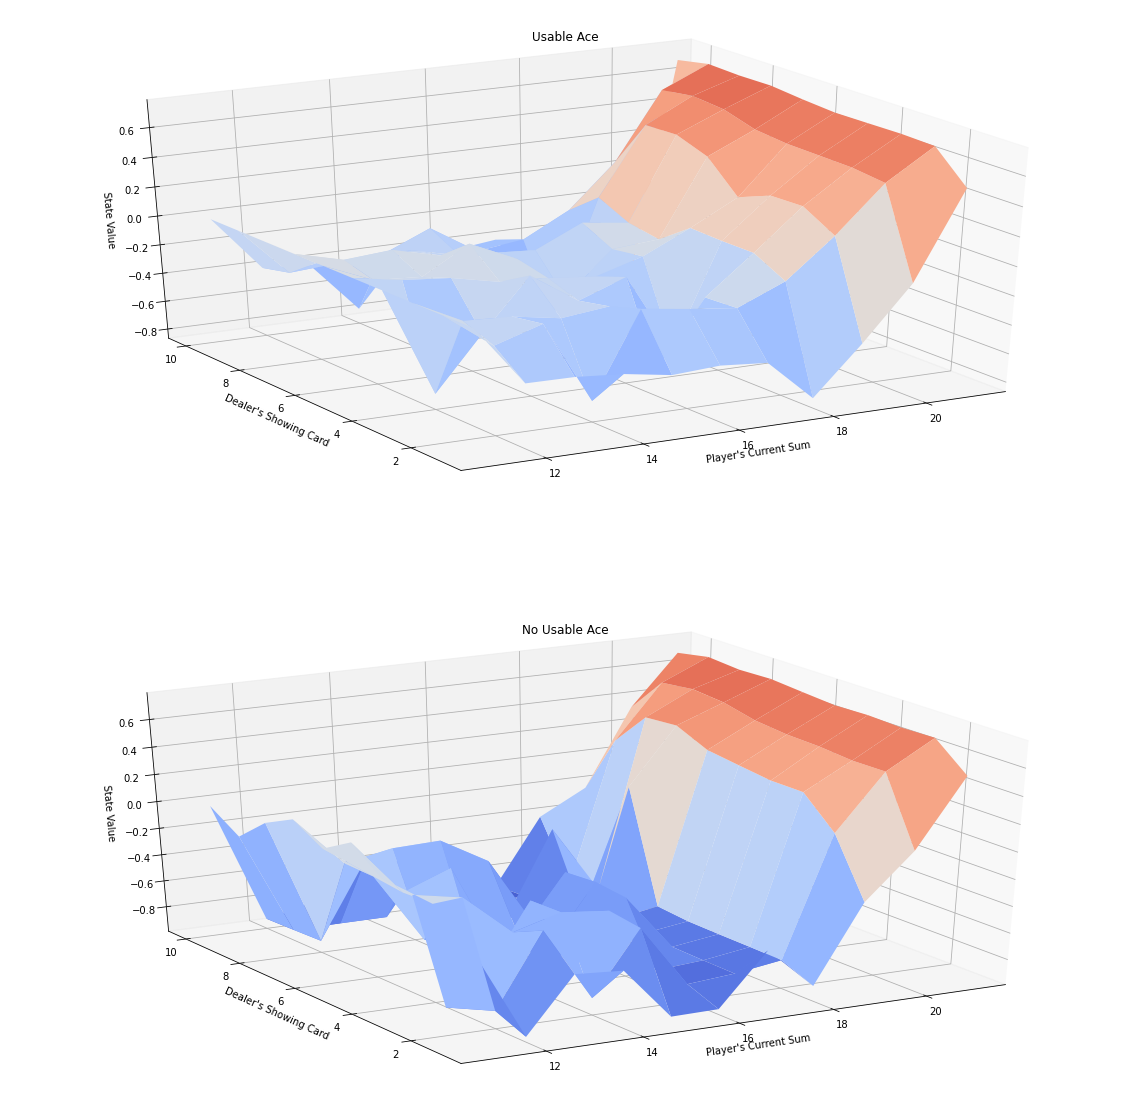

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()
    
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot) 

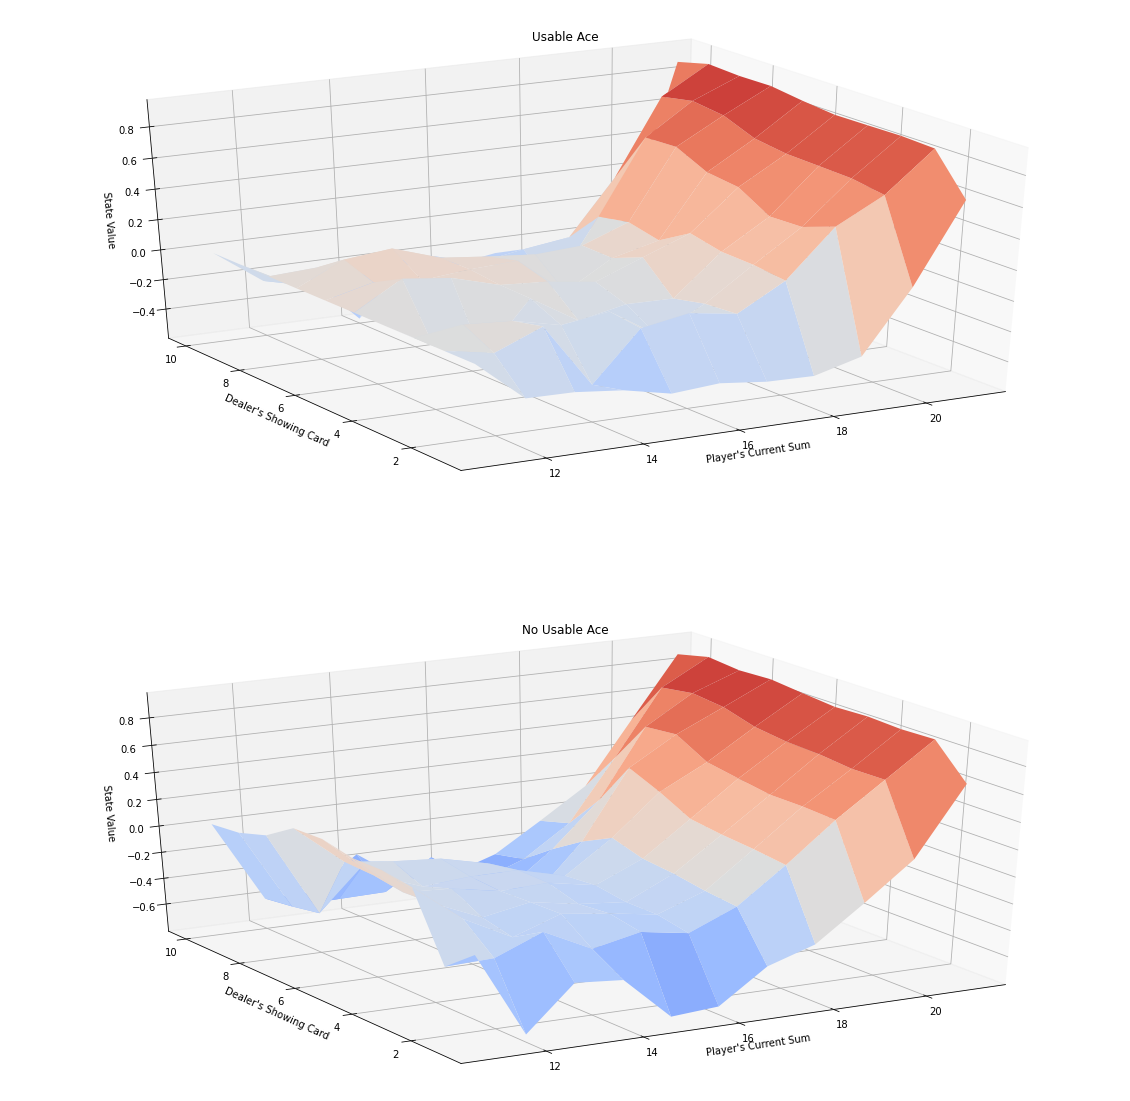

In [9]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

plot_blackjack_values(V)


Plotting the average reward of a player

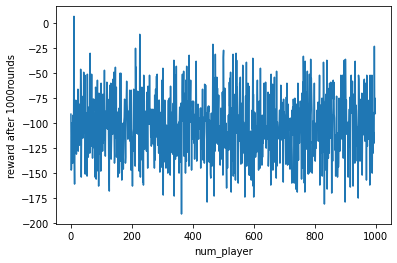

Average reward of a player after 1000 rounds is -102.826


In [10]:
import matplotlib
import matplotlib.pyplot as plt

env.reset()
calc_payoffs(env, 1000, 1000, policy)

Plotting the policy for different values of Gamma

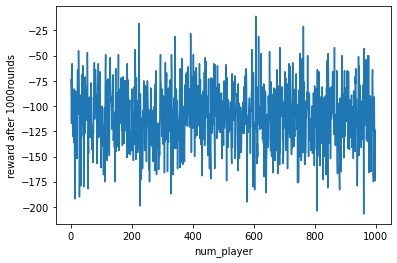

Average reward of a player after 1000 rounds is -110.65


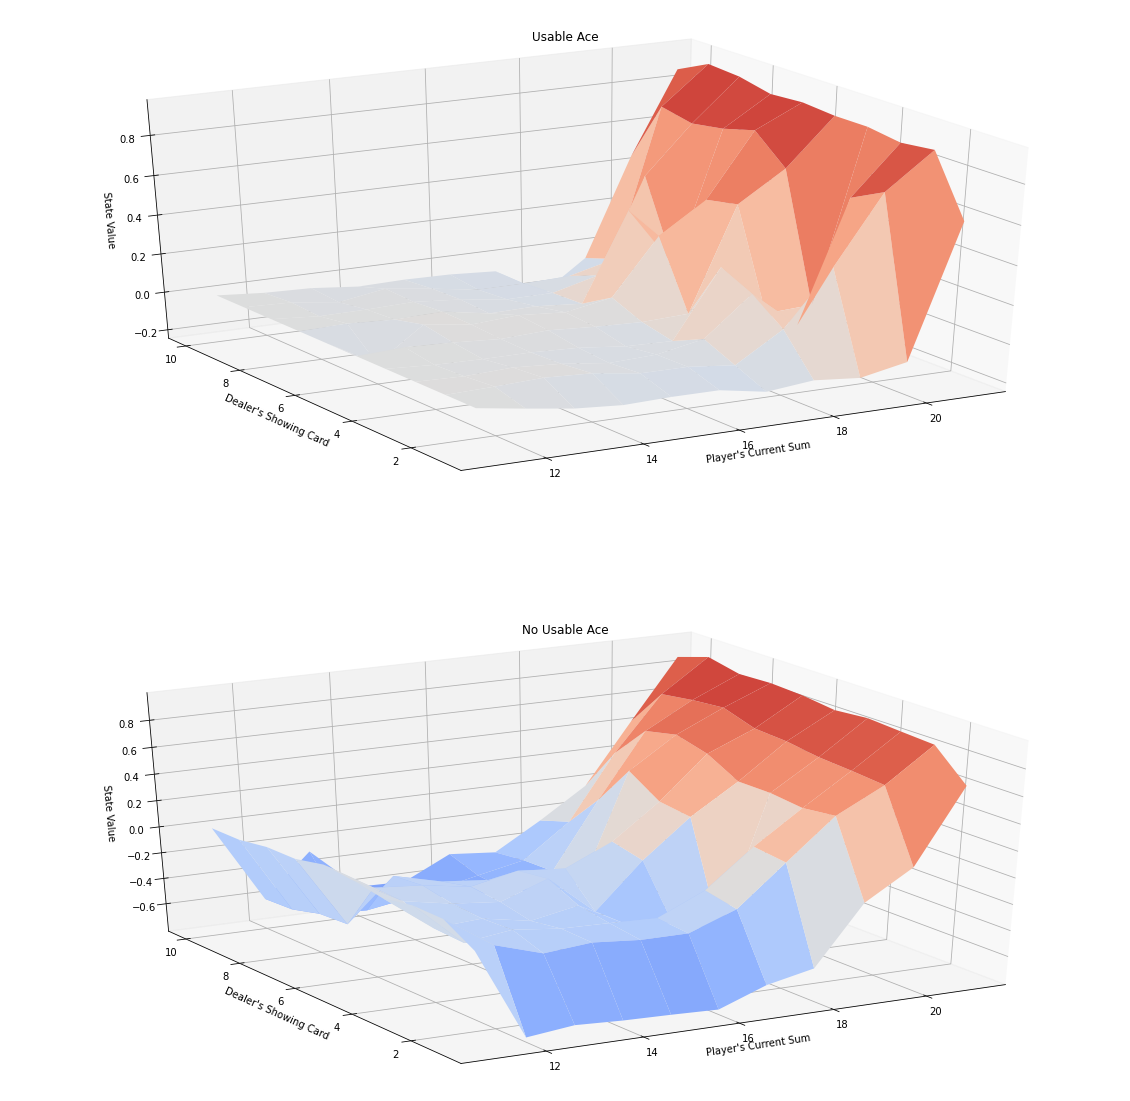

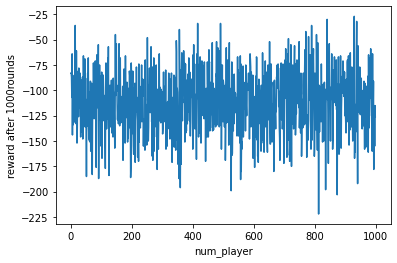

Average reward of a player after 1000 rounds is -112.644


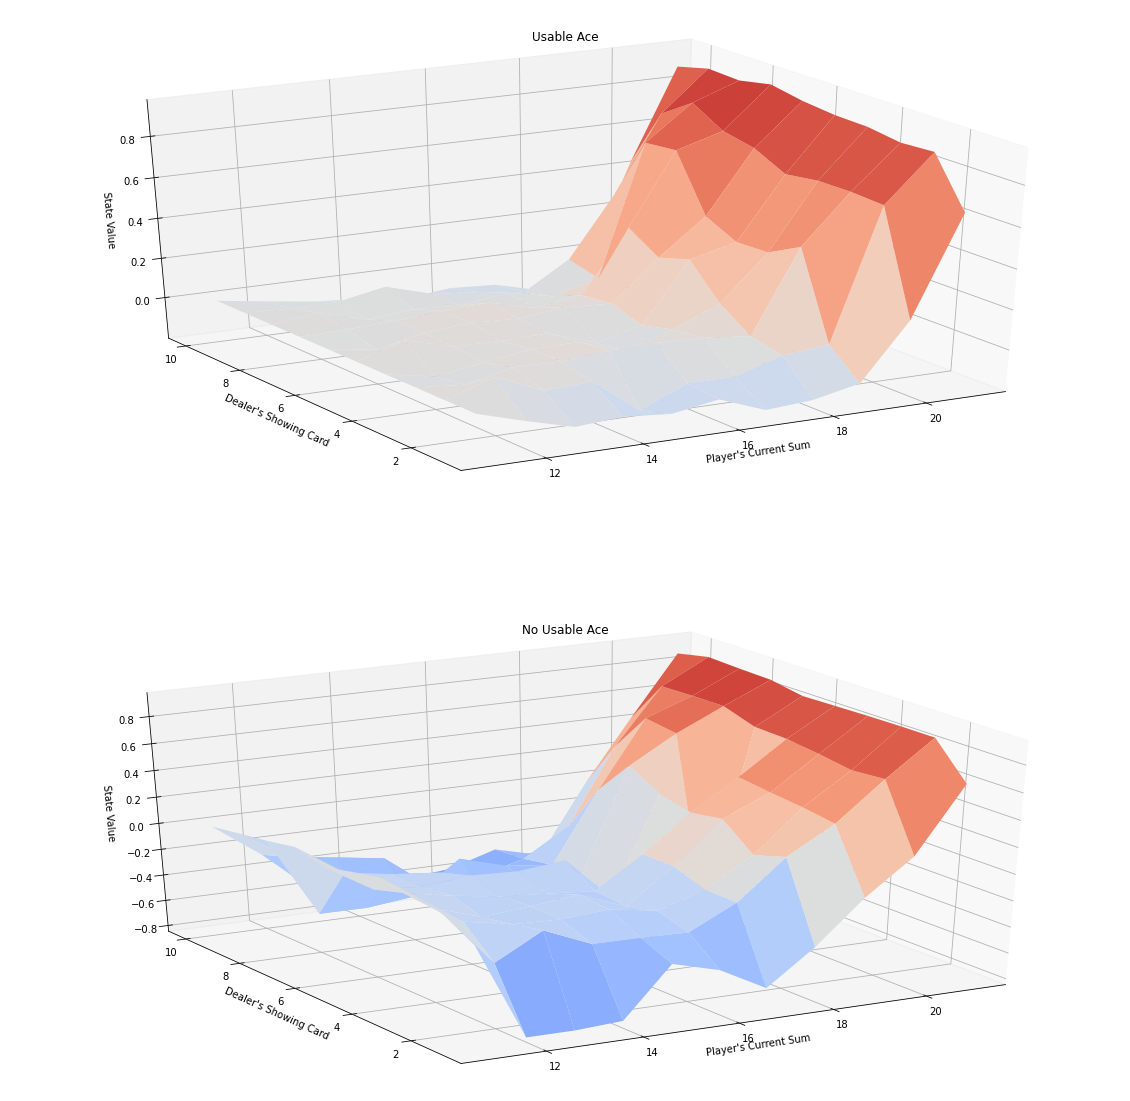

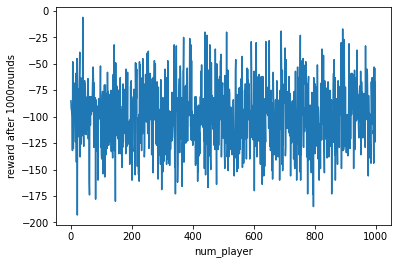

Average reward of a player after 1000 rounds is -99.716


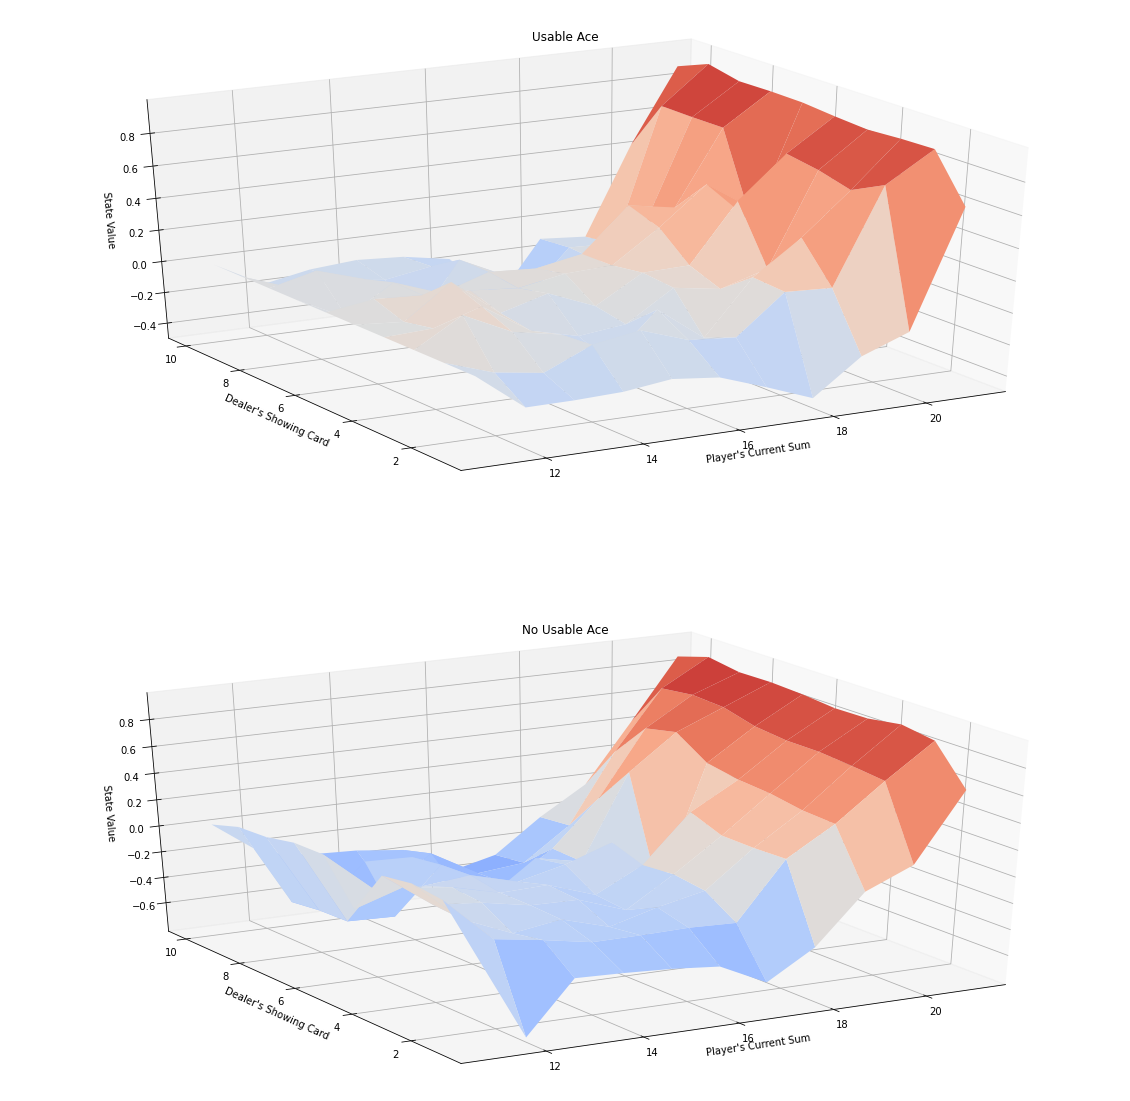

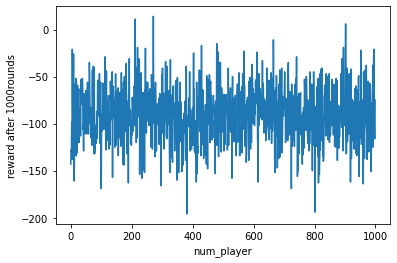

Average reward of a player after 1000 rounds is -90.808


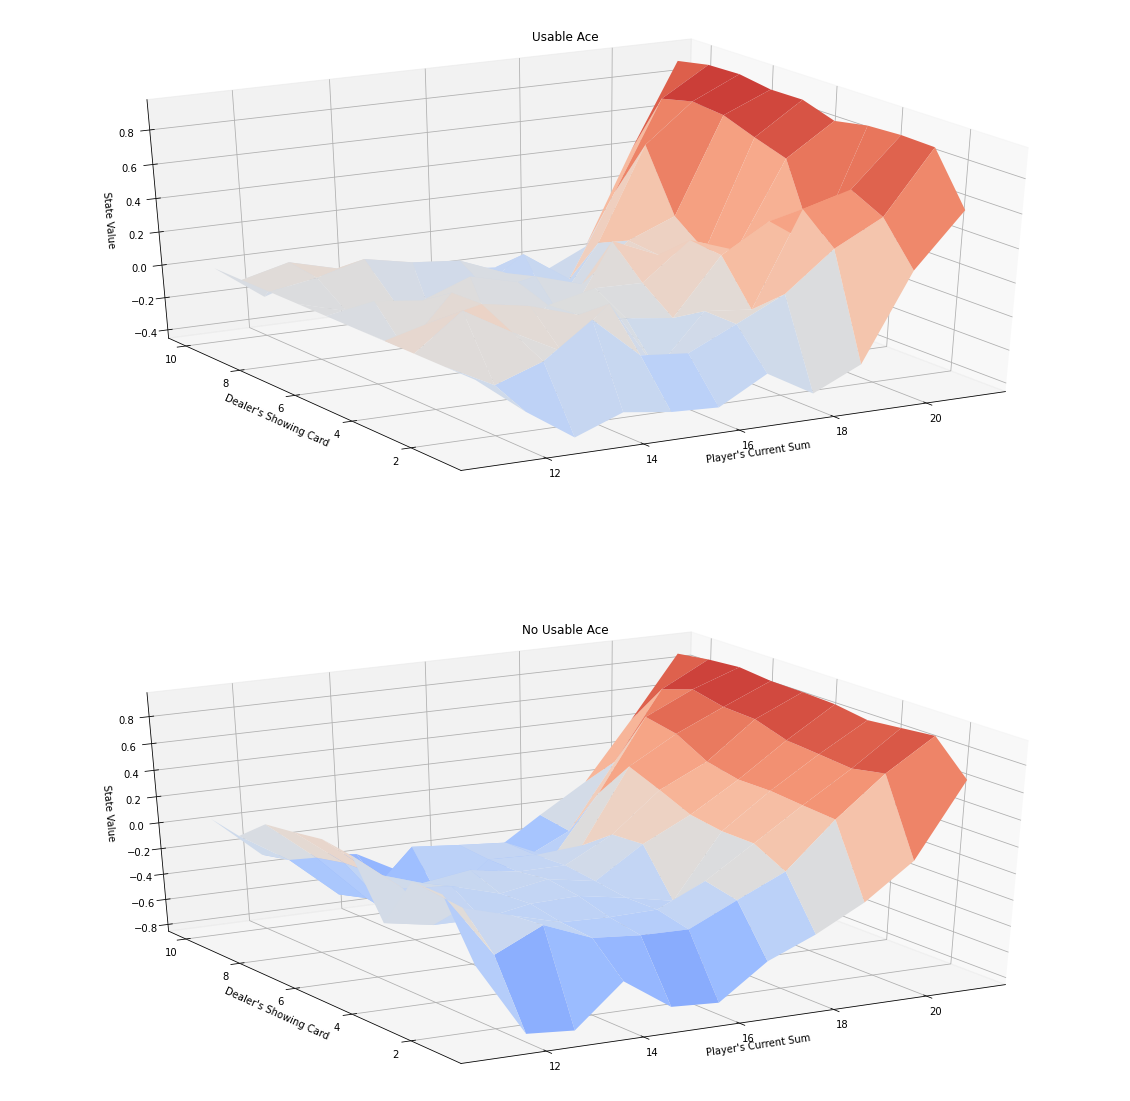

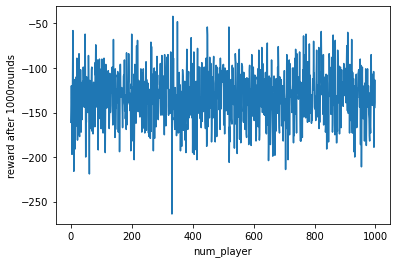

Average reward of a player after 1000 rounds is -132.312


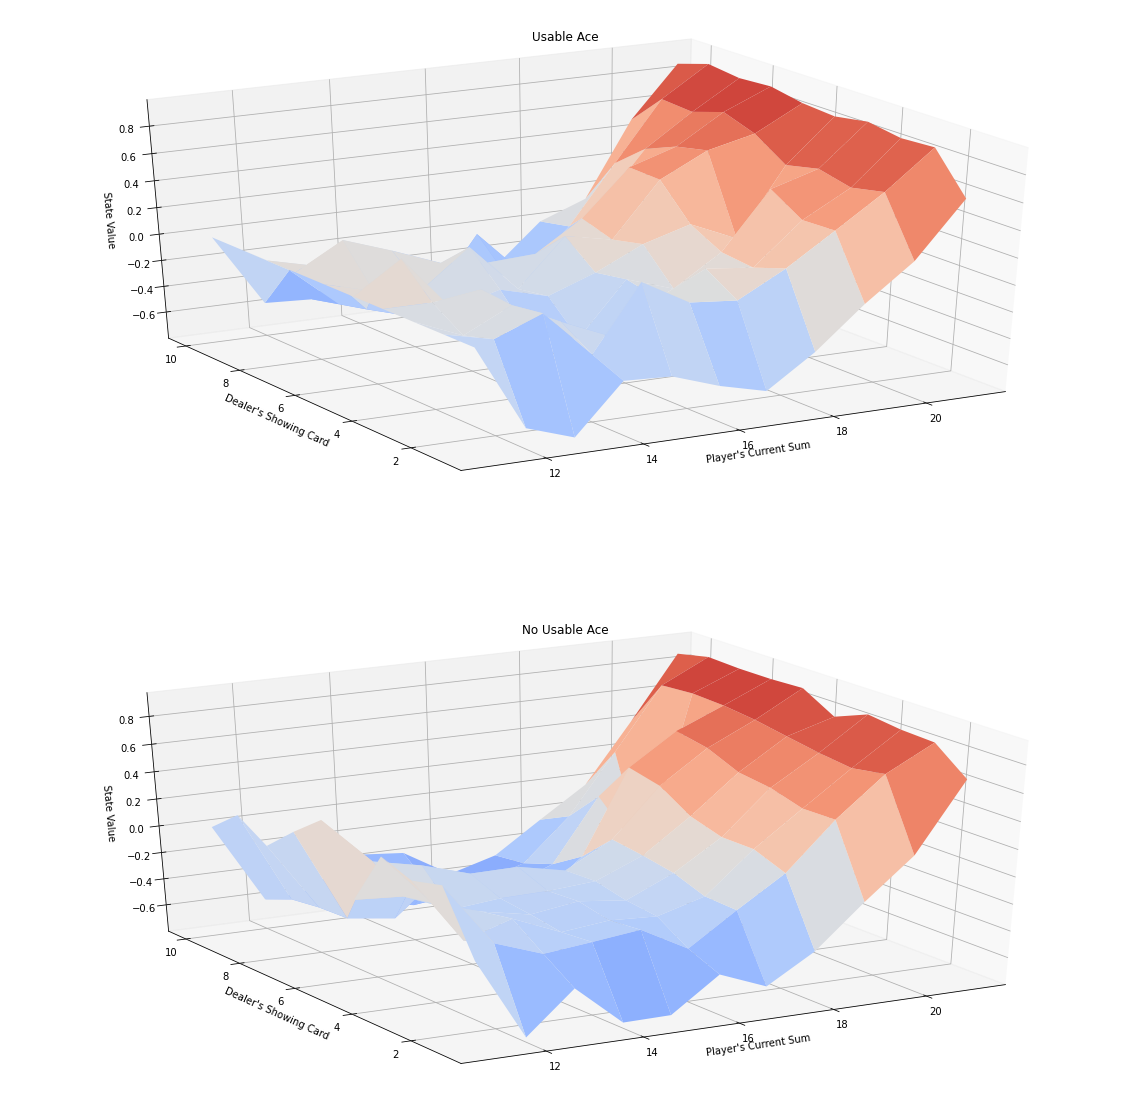

In [12]:
r = [0.3, 0.5, 0.8, 0.9, 1.0]
for g in r:
  env.reset()
  re = get_random_policy(env.action_space.n)
  Q, policy = mc_prediction(re, env, 100000, g)
  calc_payoffs(env, 1000, 1000, policy)
  V = defaultdict(float)
  for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

  plot_blackjack_values(V)

In [13]:
!apt-get update
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc --fix-missing
!pip install pypandoc

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:13 

In [14]:
!cp drive/MyDrive/Colab_Notebooks/MonteCarloBlackJack.ipynb ./


In [15]:
!jupyter nbconvert --to PDF "MonteCarloBlackJack.ipynb"

[NbConvertApp] Converting notebook MonteCarloBlackJack.ipynb to PDF
[NbConvertApp] Support files will be in MonteCarloBlackJack_files/
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Making directory ./MonteCarloBlackJack_files
[NbConvertApp] Writing 65766 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbC